Using Colab cache for faster access to the 'kepler-labelled-time-series-data' dataset.
Path to dataset files: /kaggle/input/kepler-labelled-time-series-data


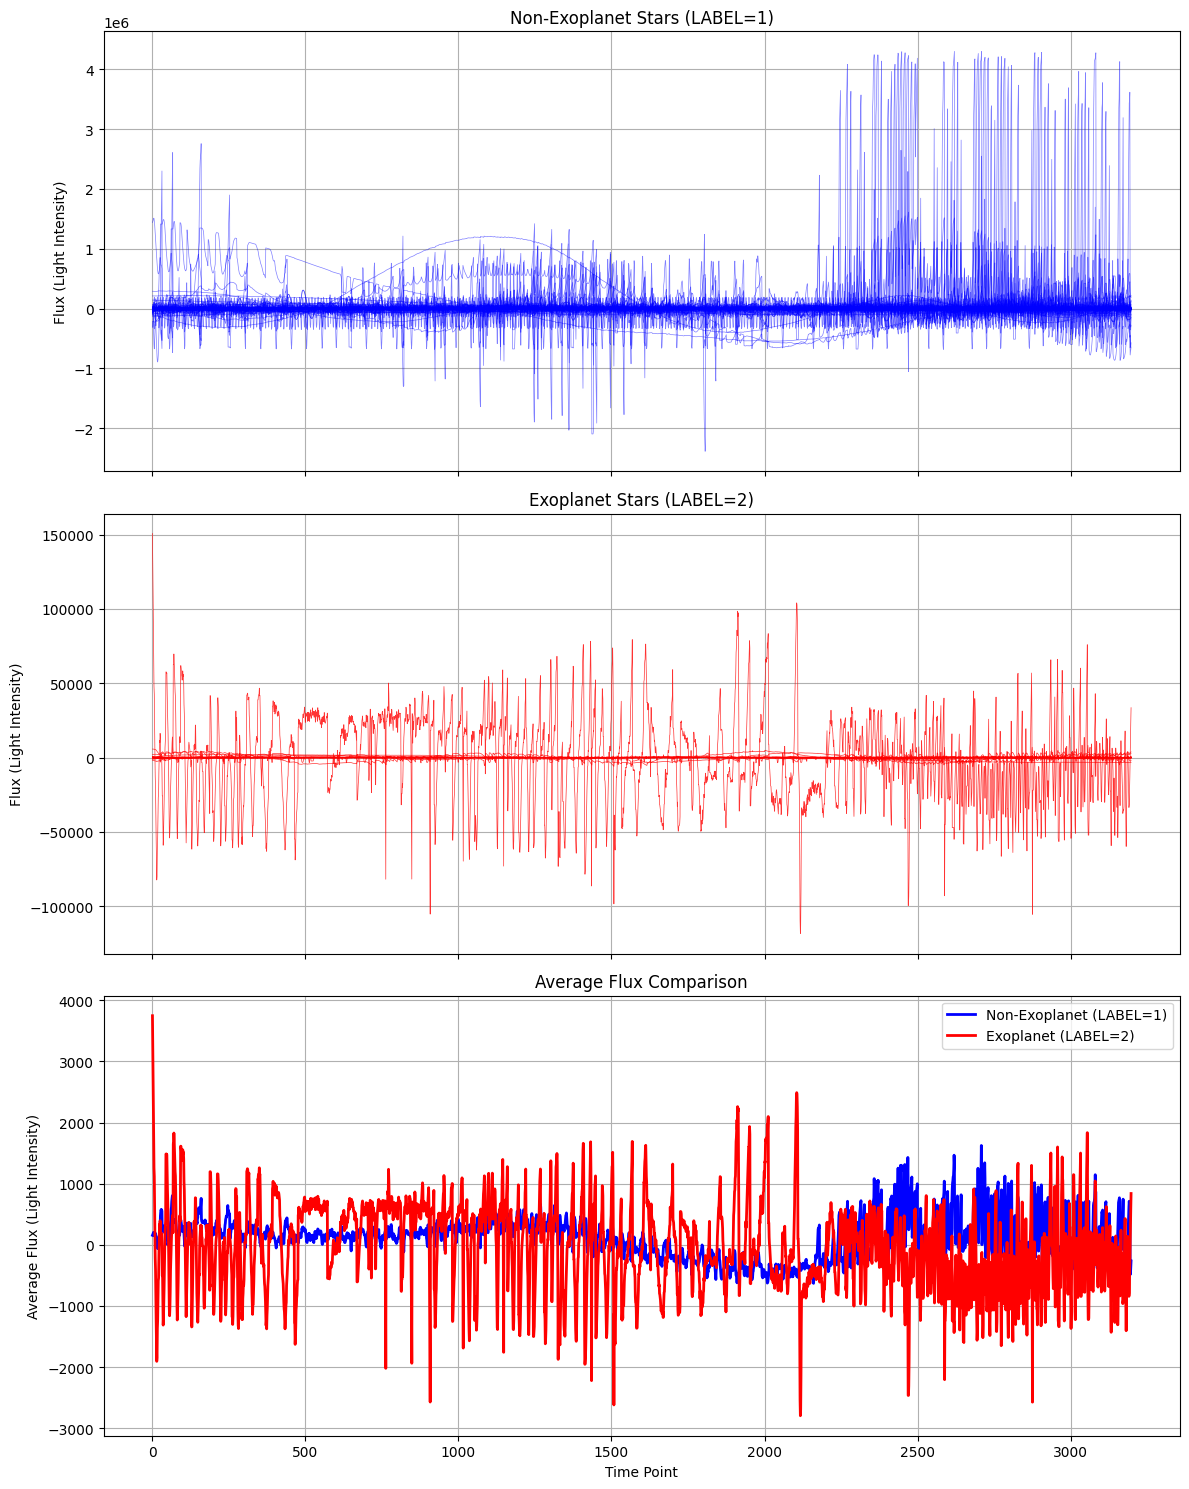

Epoch 5/100, Loss: 1.0018
Epoch 10/100, Loss: 0.9977
Epoch 15/100, Loss: 0.9863
Epoch 20/100, Loss: 0.9597
Epoch 25/100, Loss: 0.9397
Epoch 30/100, Loss: 0.9389
Epoch 35/100, Loss: 0.9393
Early stopping at epoch 39
PCA Reconstruction - ROC AUC: 0.8386, PR AUC: 0.0425
PCA Mahalanobis - ROC AUC: 0.7961, PR AUC: 0.0279
Autoencoder - ROC AUC: 0.8244, PR AUC: 0.0304


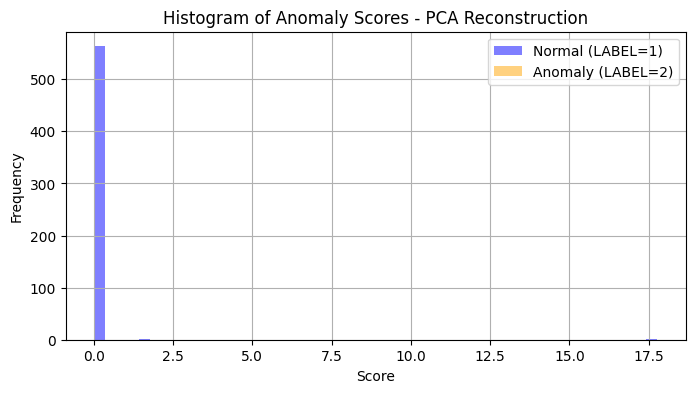

Histogram for PCA Reconstruction generated.


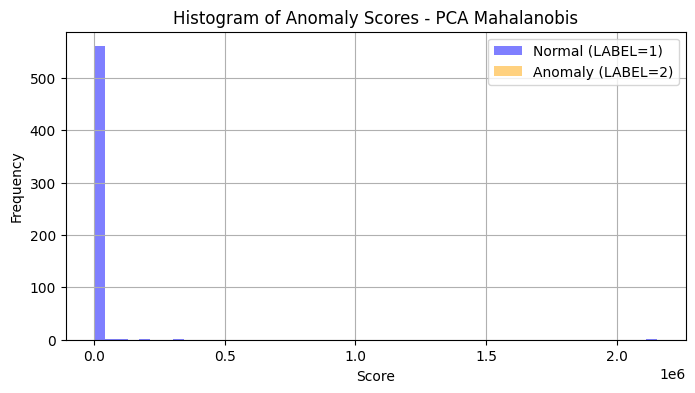

Histogram for PCA Mahalanobis generated.


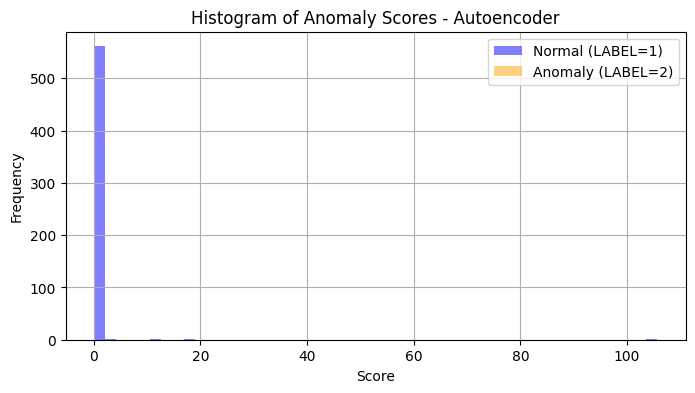

Histogram for Autoencoder generated.


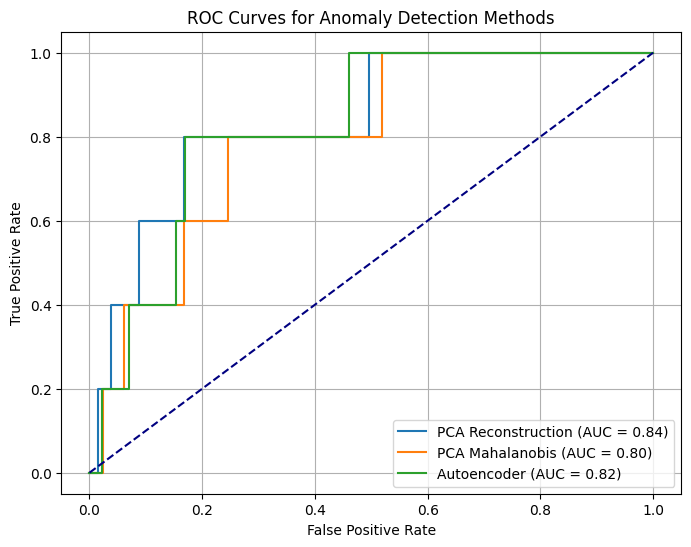

Confusion Matrix for PCA Reconstruction (Threshold: 0.0000):
[[470  95]
 [  1   4]]


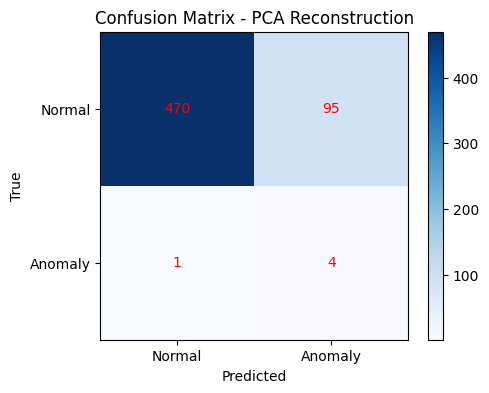

Confusion Matrix for PCA Mahalanobis (Threshold: 7.3576):
[[426 139]
 [  1   4]]


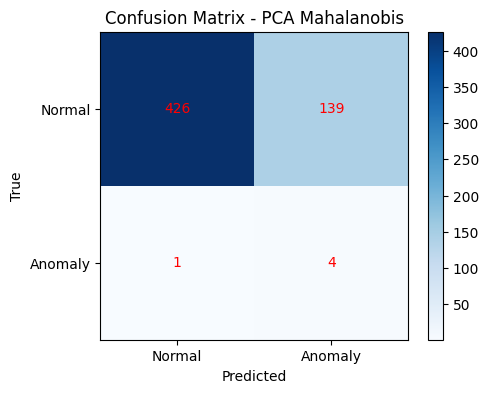

Confusion Matrix for Autoencoder (Threshold: 0.0003):
[[469  96]
 [  1   4]]


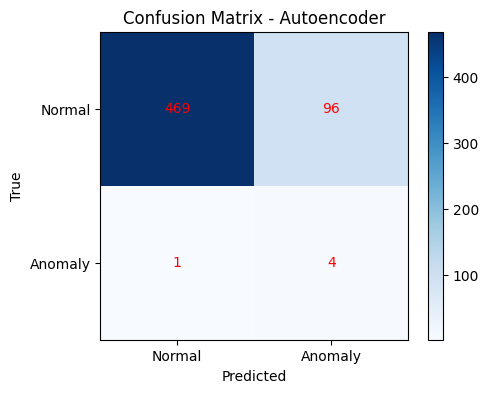

All visualizations generated. Anomalies (exoplanets) should have higher anomaly scores than normal stars in the histograms.


In [ ]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.decomposition import PCA
from scipy.fft import fft
import pywt

path = kagglehub.dataset_download("keplersmachines/kepler-labelled-time-series-data")
print("Path to dataset files:", path)

train_path = os.path.join(path, "exoTrain.csv")
test_path = os.path.join(path, "exoTest.csv")
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

df = pd.concat([train_df, test_df], ignore_index=True)

flux_columns = [col for col in df.columns if col.startswith('FLUX')]
time_points = range(1, len(flux_columns) + 1)

exoplanet_df = df[df['LABEL'] == 2]
non_exoplanet_df = df[df['LABEL'] == 1]

avg_exoplanet = exoplanet_df[flux_columns].mean()
avg_non_exoplanet = non_exoplanet_df[flux_columns].mean()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

for index, row in non_exoplanet_df.iterrows():
    flux_values = row[flux_columns].values
    ax1.plot(time_points, flux_values, color='blue', alpha=0.5, linewidth=0.5)

ax1.set_title('Non-Exoplanet Stars (LABEL=1)')
ax1.set_ylabel('Flux (Light Intensity)')
ax1.grid(True)

for index, row in exoplanet_df.iterrows():
    flux_values = row[flux_columns].values
    ax2.plot(time_points, flux_values, color='red', alpha=0.8, linewidth=0.5)

ax2.set_title('Exoplanet Stars (LABEL=2)')
ax2.set_ylabel('Flux (Light Intensity)')
ax2.grid(True)

ax3.plot(time_points, avg_non_exoplanet, color='blue', label='Non-Exoplanet (LABEL=1)', linewidth=2)
ax3.plot(time_points, avg_exoplanet, color='red', label='Exoplanet (LABEL=2)', linewidth=2)
ax3.set_title('Average Flux Comparison')
ax3.set_xlabel('Time Point')
ax3.set_ylabel('Average Flux (Light Intensity)')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

def extract_features(X):
    n_samples, n_timepoints = X.shape
    features = X.copy()

    lags = []
    for lag in range(1, 4):
        lagged = np.roll(X, -lag, axis=1)
        lagged[:, -lag:] = np.nan
        lags.append(lagged)
    lags_features = np.hstack(lags)
    row_means = np.nanmean(lags_features, axis=1, keepdims=True)
    lags_features = np.where(np.isnan(lags_features), row_means, lags_features)

    fft_features = np.abs(fft(X, axis=1))[:, 1:11]

    scales = np.arange(1, 11)
    wavelet_features = []
    for i in range(n_samples):
        coeffs, _ = pywt.cwt(X[i], scales, 'mexh')
        wavelet_features.append(np.mean(np.abs(coeffs), axis=1))
    wavelet_features = np.array(wavelet_features)

    enhanced_X = np.hstack((features, lags_features, fft_features, wavelet_features))
    return enhanced_X

normal_train = train_df[train_df['LABEL'] == 1]
X_train_raw = normal_train.drop('LABEL', axis=1).values
X_test_raw = test_df.drop('LABEL', axis=1).values
y_test = (test_df['LABEL'] == 2).astype(int)  # 0: normal, 1: anomaly

X_train_enhanced = extract_features(X_train_raw)
X_test_enhanced = extract_features(X_test_raw)

def standard_scale(X, ref_mean=None, ref_std=None):
    if ref_mean is None or ref_std is None:
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0) + 1e-8
        scaled = (X - mean) / std
        return scaled, mean, std
    else:
        return (X - ref_mean) / ref_std

X_train_scaled, scaler_mean, scaler_std = standard_scale(X_train_enhanced)
X_test_scaled = standard_scale(X_test_enhanced, scaler_mean, scaler_std)

n_comp = 200
pca = PCA(n_components=n_comp)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_train_recon = pca.inverse_transform(X_train_pca)
X_test_recon = pca.inverse_transform(X_test_pca)
pca_recon_errors = np.mean((X_test_scaled - X_test_recon)**2, axis=1)

mean_pca = np.mean(X_train_pca, axis=0)
cov_pca = np.cov(X_train_pca.T)
inv_cov = np.linalg.inv(cov_pca + np.eye(cov_pca.shape[0]) * 1e-6)
mahal_scores = np.sum((X_test_pca - mean_pca) @ inv_cov * (X_test_pca - mean_pca), axis=1)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 2048), nn.BatchNorm1d(2048), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(2048, 1024), nn.BatchNorm1d(1024), nn.ReLU(),
            nn.Linear(1024, 512), nn.BatchNorm1d(512), nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512), nn.BatchNorm1d(512), nn.ReLU(),
            nn.Linear(512, 1024), nn.BatchNorm1d(1024), nn.ReLU(),
            nn.Linear(1024, 2048), nn.BatchNorm1d(2048), nn.ReLU(),
            nn.Linear(2048, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = X_train_scaled.shape[1]
latent_dim = 64
model = Autoencoder(input_dim, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
criterion = nn.MSELoss()

dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32))
loader = DataLoader(dataset, batch_size=32, shuffle=True)

num_epochs = 100
best_loss = float('inf')
patience = 10
trigger_times = 0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in loader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    if avg_loss < best_loss:
        best_loss = avg_loss
        trigger_times = 0
    else:
        trigger_times += 1
    if trigger_times >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

model.eval()
with torch.no_grad():
    test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    recon = model(test_tensor)
    ae_errors = torch.mean((recon - test_tensor)**2, dim=1).numpy()

def compute_roc_auc(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    return auc(fpr, tpr)

def compute_pr_auc(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return auc(recall, precision)

methods = {
    'PCA Reconstruction': pca_recon_errors,
    'PCA Mahalanobis': mahal_scores,
    'Autoencoder': ae_errors
}

for name, scores in methods.items():
    roc_auc = compute_roc_auc(y_test, scores)
    pr_auc = compute_pr_auc(y_test, scores)
    print(f"{name} - ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}")

for name, scores in methods.items():
    plt.figure(figsize=(8, 4))
    plt.hist(scores[y_test == 0], bins=50, alpha=0.5, label='Normal (LABEL=1)', color='blue')
    plt.hist(scores[y_test == 1], bins=50, alpha=0.5, label='Anomaly (LABEL=2)', color='orange')
    plt.title(f'Histogram of Anomaly Scores - {name}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"Histogram for {name} generated.")

plt.figure(figsize=(8, 6))
for name, scores in methods.items():
    fpr, tpr, _ = roc_curve(y_test, scores)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {compute_roc_auc(y_test, scores):.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Anomaly Detection Methods')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

def get_optimal_threshold(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    youden = tpr - fpr
    optimal_idx = np.argmax(youden)
    return thresholds[optimal_idx]

for name, scores in methods.items():
    threshold = get_optimal_threshold(y_test, scores)
    y_pred = (scores >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {name} (Threshold: {threshold:.4f}):")
    print(cm)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.colorbar()
    plt.xticks([0, 1], ['Normal', 'Anomaly'])
    plt.yticks([0, 1], ['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

print("All visualizations generated. Anomalies (exoplanets) should have higher anomaly scores than normal stars in the histograms.")